# Model selection using information criteria

author: Audrey Olivier

Theory background: model selection refers to the task of selecting a statistical model from a set of candidate models, given some data. A good model is amodel that is able to explain the data well (high model evidence). Given models of same explanatory power, the simplest model should be chosen (Ockam razor). Several simple criteria can be used to compute a model's quality and thus perform model selection. UQpy implements three citeria: 
<br>
Bayesian information criterion (BIC)
$$ BIC = ln(n) k - 2 ln(\hat{L}) $$

Akaike information criterion (AIC)
$$ AIC = 2 k - 2 ln (\hat{L})  $$

Corrected formula for AIC (AICc), for small data sets 
$$ AICc = AIC + \frac{2k(k+1)}{n-k-1} $$

For all formula above, $k$ is the number of parameters characterizing the model, $\hat{L}$ is the maximum value of the likelihood function and $n$ the number of data points. The best model is the one that minimizes the cirterion. All three formulas have a model fit term (find the model that minimizes the negative log likelihood) and a penalty term that increases as the number of model parameters (model complexity) increases.

Reference: *Burnham, K. P.; Anderson, D. R. (2002), Model Selection and Multimodel Inference: A Practical Information-Theoretic Approach (2nd ed.), Springer-Verlag, ISBN 0-387-95364-7*

## Example 1: selection between different univariate distributions

In [1]:
# import the required packages
from UQpy.Inference import Model, InfoModelSelection
from UQpy.RunModel import RunModel
import numpy as np
import matplotlib.pyplot as plt

Generate data using a gamma distribution.

In [2]:
from scipy.stats import gamma
data = gamma(a = 2, loc = 0, scale = 1).rvs(size=200)
print(data.shape)

(200,)


Define the models to be compared, then call InfoModelSelection to perform model selection. By default, InfoModelSelection returns its outputs, fitted parameters, value of the chosen criteria, model probabilities and so on, in a sorted order, i.e., starting with the most probable model. However, if setting sorted_ouputs=False, the class output attributes are given in the same order as the candidate_models.

In [3]:
# Define the models to be compared, for each model one must create an instance of the model class
model_names = ['exponential', 'gamma', 'chisquare']
n_params_list = [2, 3, 3]
candidate_models = []
for i, model_name in enumerate(model_names):
    M = Model(model_name = model_name, model_type = 'pdf', n_params=n_params_list[i])
    candidate_models.append(M)

Sorted model using BIC criterion: chisquare, gamma, exponential
Sorted model using AIC criterion: chisquare, gamma, exponential
Sorted model using AICc criterion: chisquare, gamma, exponential


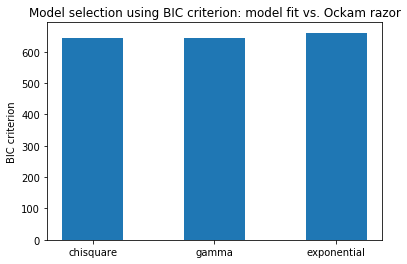

Shape parameter of the gamma distribution: 1.7012149745900915
DoF of the chisquare distribution: 3.4023804724687285


In [4]:
# Perform model selection using different information criteria
criteria = ['BIC', 'AIC', 'AICc']
for criterion in criteria:
    selector = InfoModelSelection(candidate_models = candidate_models, data = data, method = criterion)
    print('Sorted model using '+criterion+' criterion: '+', '.join(x for x in selector.sorted_model_names))
    if criterion == 'BIC':
        criterion_value = selector.sorted_criteria
        sorted_names = selector.sorted_model_names
        param = selector.sorted_fitted_params
        
width = 0.5
ind = np.arange(len(sorted_names))
p1 = plt.bar(ind, criterion_value, width = width)
#p2 = plt.bar(ind, criterion_value-data_fit_value, bottom=data_fit_value, width = width)

plt.ylabel('BIC criterion')
plt.title('Model selection using BIC criterion: model fit vs. Ockam razor')
plt.xticks(ind, sorted_names)
#plt.legend((p1[0], p2[0]), ('Data fit', 'Ockam razor'))

plt.show()

print('Shape parameter of the gamma distribution: {}'.format(param[sorted_names.index('gamma')][0]))
print('DoF of the chisquare distribution: {}'.format(param[sorted_names.index('chisquare')][0]))

Note that here both the chisquare and gamma are capable of explaining the data, with $a = \nu/2$, $a$ is gamma's shape parameter and $\nu$ is the number of DOFs in chi-square distribution.

## Example 2: model selection in regression -  $y=X \theta + \epsilon$

In [5]:
# Generate data from a quadratic function
from scipy.stats import multivariate_normal

param_true = np.array([1.0, 2.0]).reshape(1, -1)
error_covariance = np.eye(50)

print(param_true.shape)
z = RunModel(samples=param_true, model_script='pfn_models.py', model_object_name = 'model_quadratic', 
             var_names = ['theta_0', 'theta_1'])
data = z.qoi_list[0].reshape((-1,))+multivariate_normal.rvs(mean=None, cov=error_covariance, size=1)
print(data)

(1, 2)
[  1.35566176  -0.8729938   -0.44785855  -0.44896173   1.72200234
   2.59812939   4.23754964   4.64700102   6.78438905   7.87105515
  11.4892097   11.72143168  15.54728058  16.55293981  18.24100107
  21.48390285  26.17720377  26.98057663  31.04181793  34.47892764
  38.09808082  40.90835192  45.66911299  49.35117617  53.55930399
  57.35359807  62.11447015  65.97931265  70.97195294  75.51443656
  81.16731878  86.05444905  92.5011192   96.75448771 103.35407999
 110.18861314 115.39692374 121.95298127 128.02581736 134.74560637
 140.52194057 148.27991555 155.56697382 162.97936837 170.05912565
 176.58407552 184.86704271 193.93380811 200.69923917 210.26397735]


In [6]:
# Create instances of the Model class for three models: linear, quadratic and cubic
names = ['linear', 'quadratic', 'cubic']
candidate_models = []
for i in range(3):
    M = Model(model_type='python', n_params=i+1,
              model_script='pfn_models.py', model_object_name = 'model_'+names[i],
              model_name=names[i], error_covariance=error_covariance)
    candidate_models.append(M)

Apart from the data, candidate models and method (BIC, AIC...), InfoModelSelection also takes as inputs lists of inputs to the maximum likelihood class (iter_optim, method_optim, ...). Those inputs should be lists of length len(candidate_models).

In [7]:
# Perform model selection using BIC criterion
selector = InfoModelSelection(candidate_models = candidate_models, data = data, method = 'BIC', 
                              method_optim=['nelder-mead']*3)
print('Sorted models: ', selector.sorted_model_names)
print('Value of criteria: ', selector.sorted_criteria)
print('Value of penalty term (complexity)', selector.sorted_penalty_terms)
print(selector.sorted_probabilities)

Sorted models:  ['quadratic', 'cubic', 'linear']
Value of criteria:  [124.66177969129261, 127.77729779809115, 25561.737563582414]
Value of penalty term (complexity) [7.824046010856292, 11.736069016284437, 3.912023005428146]
[0.8260315565265062, 0.17396844347349374, 0.0]


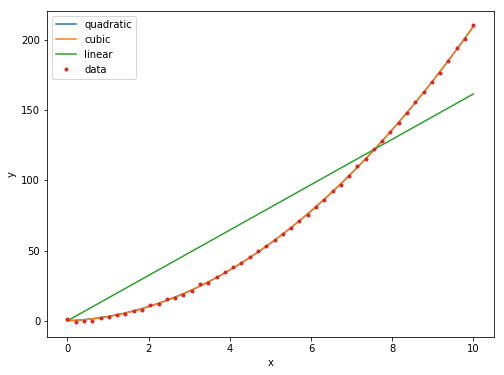

In [8]:
# Plot the results
domain = np.linspace(0, 10, 50)
fig, ax = plt.subplots(figsize=(8,6))

var_names = ['theta_0', 'theta_1']
for i in range(3):
    var_names = ['theta {}'.format(j) for j in range(i+1)]
    z = RunModel(samples=selector.sorted_fitted_params[i].reshape((1,-1)), 
                 model_object_name = 'model_'+selector.sorted_model_names[i],
                 model_script='pfn_models.py')
    y = z.qoi_list[0].reshape((-1,))
    ax.plot(domain, y, label = selector.sorted_model_names[i])

plt.plot(domain, data, linestyle='none', marker='.', label='data')
plt.xlabel('x')
plt.ylabel('y')
    
plt.legend()
plt.show()

For this case, one can observe that both the quadratic and cubic model are capable of explaining the data. The cubic model is penalized due to its higher complexity (penalty_term) and thus the quadratic model is preferred.